In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install rdkit-pypi
  !pip install pyscf[all]
  !pip install py3Dmol
  !rm -rf sample_data
  !git clone https://github.com/beangoben/molecular_screening_lecture.git
  !mv molecular_screening_lecture/* . 
  !rm -rf molecular_screening_lecture

     |████████████████████████████████| 22.3 MB 1.4 MB/s 
     |████████████████████████████████| 37.5 MB 1.4 MB/s 
     |████████████████████████████████| 183 kB 55.7 MB/s 
     |████████████████████████████████| 40.9 MB 1.7 MB/s 
     |████████████████████████████████| 29.7 MB 1.3 MB/s 
Cloning into 'molecular_screening_lecture'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 3), reused 35 (delta 2), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [2]:
%load_ext autoreload
%autoreload 2

# Quantum Chemistry, Solar cells<br> and Molecular Screening

This colab will guide trough some of the current efforts in utilizing theoretical chemistry methods to solve material problems, via high-throughput screensing of molecules. You'll get a sense of what it's like to generate and run calculations on a larger scale molecular library. Molecular libraries are being used to screen for molecules with promising properties in the fields of organic photovoltaics, organic LED's, flow batteries, among many others.

We'll pretend that we're building and screening a library of organic molecules for photovoltaics applications. Once we have some electronic structure properties of the molecules (specifically, estimates for the HOMO and LUMO energies), we'll use a simple model called the Scharber Model to predict the Energy Conversion efficiency that we'd obtain if we used these molecules as donor molecules in an organic solar cell.


It is divided in 4 parts:

* Intro Quantum Chemistry Calculations with Pyquante
* Generating multiple molecules with RDKIT
* Modeling Power Conversion Efficiency of Dye sensitive solar cells with the Scharber Model
* Screening of molecules

It might seem really long, but that is because there is a lot of ideas to cover...we have kept a lot of the code light so that you focus more on the ideas.

This aplication is based off on the Harvard Clean Energy Project, which was led by the Aspuru Guzik at Harvard University (Now MatterLab @ UofT)


**NOTE:** The purpose of the notebook is just to give you a feel for large scale molecular screening. Since we'll be running many calculations in your laptop's virtual machine, we'll have to use relatively cheap and fast methods called Semi-Empirical methods. So don't trust the values that we predict too much...

## Load preliminaries

In [3]:
import ast
# The scientific python toolkit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Nice progress bar
import tqdm.auto as tqdm

# An incredible chemoinformatics library
import rdkit
from rdkit.Chem import AllChem
import rdkit.Chem.Draw as rdDraw
from rdkit.Chem.Draw.IPythonConsole import drawMol3D
# An python based eletronic structure package
# Also check out PSI4
import pyscf
from pyscf.semiempirical import MINDO3
# 3D molecule viewer, interally used by rdkit
import py3Dmol

for mod in [np, sp, pd, rdkit, pyscf, py3Dmol]:
  print(f'{mod.__name__:15s} : {mod.__version__}')

numpy           : 1.21.5
scipy           : 1.4.1
pandas          : 1.3.5
rdkit           : 2021.09.5
pyscf           : 1.7.6
py3Dmol         : 1.8.0


In [4]:
# Nice plotting settings.
sns.set_style("white")
plt.rcParams["figure.figsize"] = (12,8)
sns.set_context("talk", font_scale=1.25, rc={"lines.linewidth": 2.5})
%config InlineBackend.figure_format = 'retina'

# <i class="fa fa-check-circle-o"></i> Let's build our search space with a Molecular library

The molecules we are interested in making are for Dye Sensitive Solar cells (DSSC) , here is a diagram of one:

[![](https://github.com/beangoben/molecular_screening_lecture/blob/main/media/dye.png?raw=1)](https://en.wikipedia.org/wiki/Dye-sensitized_solar_cell)

One of the most important part in this solar cell is the **dye**, the molecules that compose this part absorb more readily photons of a certain frequency.
The color of the dye is determined by the band gap, the frequencies less than the gap are reflected and those higher than the gap are absorbed.  So bandgap of the molecules that comprise the dye are directly related to efficiency of a DSSC.

If we want to build a good DSSC we need a molecule with the following properties:

* Organic, since it will be cheaper and more eco-friendly.
* Easily Synthesizable (Can be synthesized in a few common steps from common materials).
* Colored, so that it can absorb specific frequencies of light.
* And hence a band-gap, that will give us a good power efficency when taking into account the solar spectrum.

With this in mind we can start building our molecules!



## a) Defining reactions and fragments
The first step to start using rdkit to make our molecular library is to define the types of "reactions" that are allowed. Without going into too much detail, the two lines below define two different types of reactions: fusion and linking. You'll get a sense of what they mean further down.

In [9]:
linking_reaction = AllChem.ReactionFromSmarts('[cH1,nH1:1].[cH1:2]>>[*:1]-[*:2]')
fusion_reaction = AllChem.ReactionFromSmarts('[a:7]~1~[a:8]~[a:9]~[cH:1][cH:2]~[a:10]~1.[a:5][c;H1:3][c;H1:4][a:6]>>[*:7]~1~[*:8]~[*:9]~[*:1](:[*:5])~[*:2](:[*:6])~[*:10]~1.[*:3][*:4]')

Next, we'll define the set of fragments from which we'll build our entire molecular library. The fragments are defined in a string format that is now as the SMILES string format.  **SMILES** stands for simplified molecular-input line-entry system.

You can read up on the specifics of the syntax in the [webs](http://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system).

In [10]:
#This is the list of fragments, in SMILES format,  that we'll be working with: 
fragments = ["C1=CC=CC=C1","C1=CC=NC=C1","N1=CC=NC=C1","N1C=CC=C1","O1C=CC=C1"]

Ok, so now we have those fragments.... but what do they look like? 

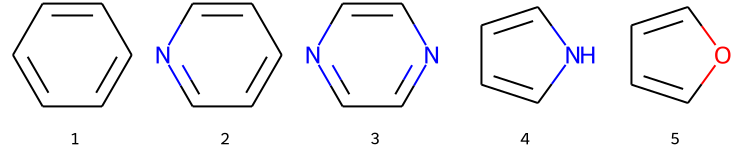

In [11]:
reactants = [AllChem.MolFromSmiles(i) for i in fragments]
labels = [str(i+1) for i in range(6)]
rdDraw.MolsToGridImage(reactants, legends = labels, molsPerRow = 5, subImgSize=(150,150))    

### <i class="fa fa-question-circle"></i>  Do you recognize them? 

0. Benzene
1. Pyridine
2. Pyrazine
3. Pyrrole
4. Furan

## b) Building the 1st generation library 
As a next step, we'll start "mating" these fragments, in order to generate molecules that are composed of pairs of fragments.  These pairs can either be "linked" or they can be "fused"

### I'll first show you what I want you to do for a single pair of fragments:

### Linking

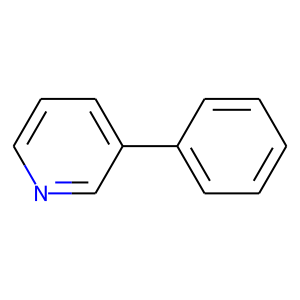

In [12]:
products = [] #start with an empty set
#get a single pair of fragments
r1 = reactants[0]
r2 = reactants[1]
#React them
prods = linking_reaction.RunReactants((r1, r2))
#Store all the products, in smiles format, in the products set
for prod in prods:
    product_SMILES = AllChem.MolToSmiles(prod[0])
    products.append(product_SMILES)

# converto a mol from a smiles an draw
link_mol = AllChem.MolFromSmiles(products[-1])
rdDraw.MolToImage(link_mol)

### Fusion

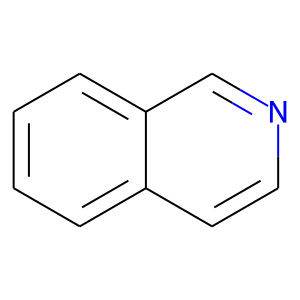

In [13]:
products = [] #start with an empty set
#get a single pair of fragments
r1 = reactants[0]
r2 = reactants[1]
#React them
prods = fusion_reaction.RunReactants((r1, r2))
#Store all the products, in smiles format, in the products set
for prod in prods:
    product_SMILES = AllChem.MolToSmiles(prod[0])
    products.append(product_SMILES)
    
# converto a mol from a smiles an draw
fusion_mol = AllChem.MolFromSmiles(products[-1])
rdDraw.MolToImage(fusion_mol)

### Here is where the fun starts.  

Write two nested for-loops:
* #### The first nested for-loop will react all pairs of fragments using the linking reaction. 
* #### The second nested for-loop will react all pairs of fragments using the fusion reactions. 

At the end of each nested for-loop, store the products in the products set! 

In [14]:
products1 = set()

#Linking reactions:
for r1 in reactants:
    for r2 in reactants:
        for prod in linking_reaction.RunReactants((r1, r2)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products1.add(product_SMILES)

#Fusion reactions:
for r1 in reactants:
    for r2 in reactants:
        for prod in fusion_reaction.RunReactants((r1, r2)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products1.add(product_SMILES)
            
products1 = np.array(list(products1))
print(f'The total number of 1st generation molecules is ---> {len(products1)}')

The total number of 1st generation molecules is ---> 87


### <i class="fa fa-eye"></i> Let's look a the products
The products are smiles strings (you can verify by printing products).
We want to see what they look like, so we'll convert the smiles to rdkit molecules. 

In [15]:
gen1 = [AllChem.MolFromSmiles(i) for i in products1]

Now let's see what our first generation library looks like: 

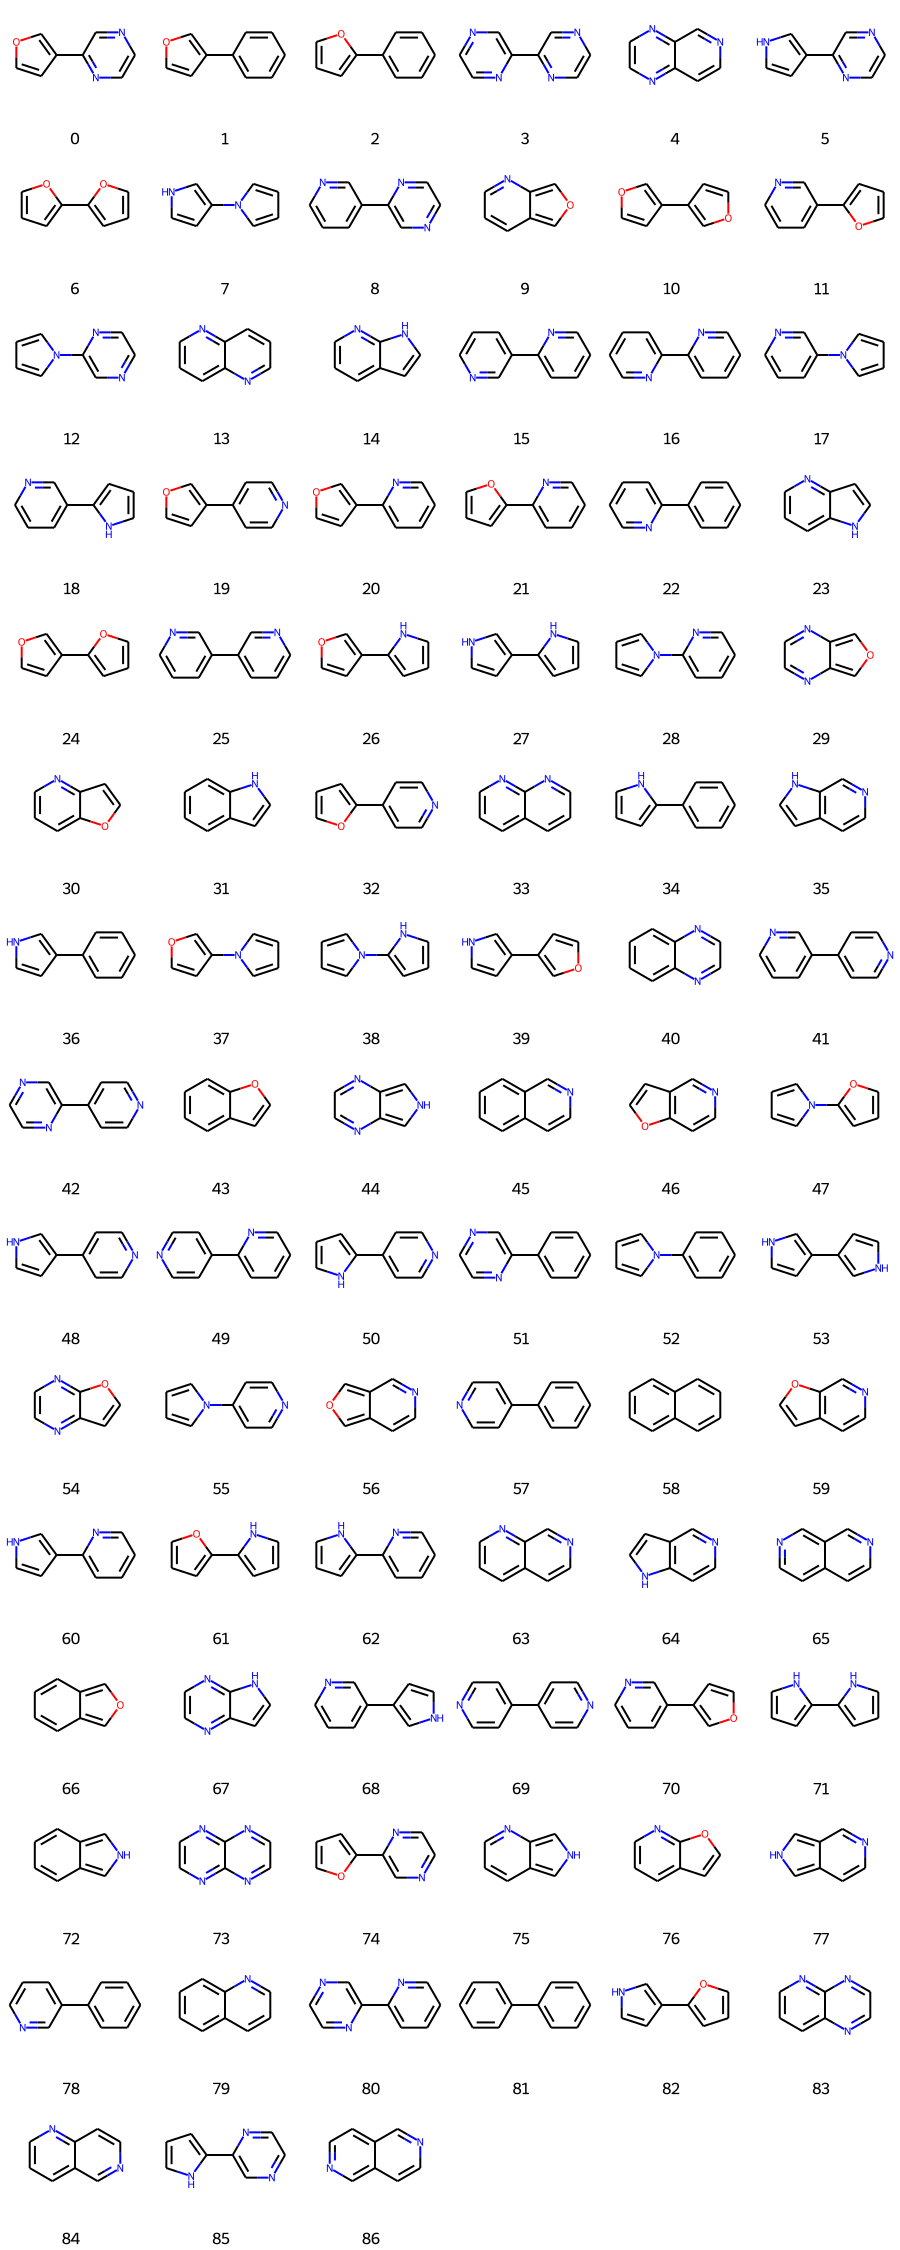

In [16]:
labels = [str(i) for i in range(len(gen1))]
rdDraw.MolsToGridImage(gen1, legends = labels,
                       molsPerRow = 6, subImgSize=(150,150), maxMols=200)

<i class="fa fa-smile-o"></i> One happy family!


## c) Second generation Library:
Let's take it to the next step! Let's take all the molecules in the list of two-fragment products, and "react" them again with the set of fragments in order to generate a library of three-fragment products. 

### Write again two nested for-loops  
* The first nested for-loop will react all molecules in reactants with all of the fragments using the linking reaction. 
* The second nested for-loop will react all molecules in reactants with all of the fragments using the fusion reaction.

Keep adding the resulting molecules to the list of molecules

#### **NOTE:** since we want to mix all the 1st generation products with the fragments, one for-loop should loop over reactants, while the other should loop over gen1!

In [17]:
#First for loop: linking reactions
products2 = set()

for r1 in reactants:
    for r3 in gen1:
        for prod in linking_reaction.RunReactants((r1, r3)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products2.add(product_SMILES)

#Second nested for-loops: fusion reactions. 
for r1 in reactants:
    for r3 in gen1:
        for prod in fusion_reaction.RunReactants((r1, r3)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products2.add(product_SMILES)

products2 = np.array(list(products2))
print(f'The total number of 2nd generation molecules is ---> {len(products2)}')

The total number of 2nd generation molecules is ---> 3500


These are way too many molecules to display in our iPython notebook, so in order to visualize them, we'll take a random subset of them, of size 200. 

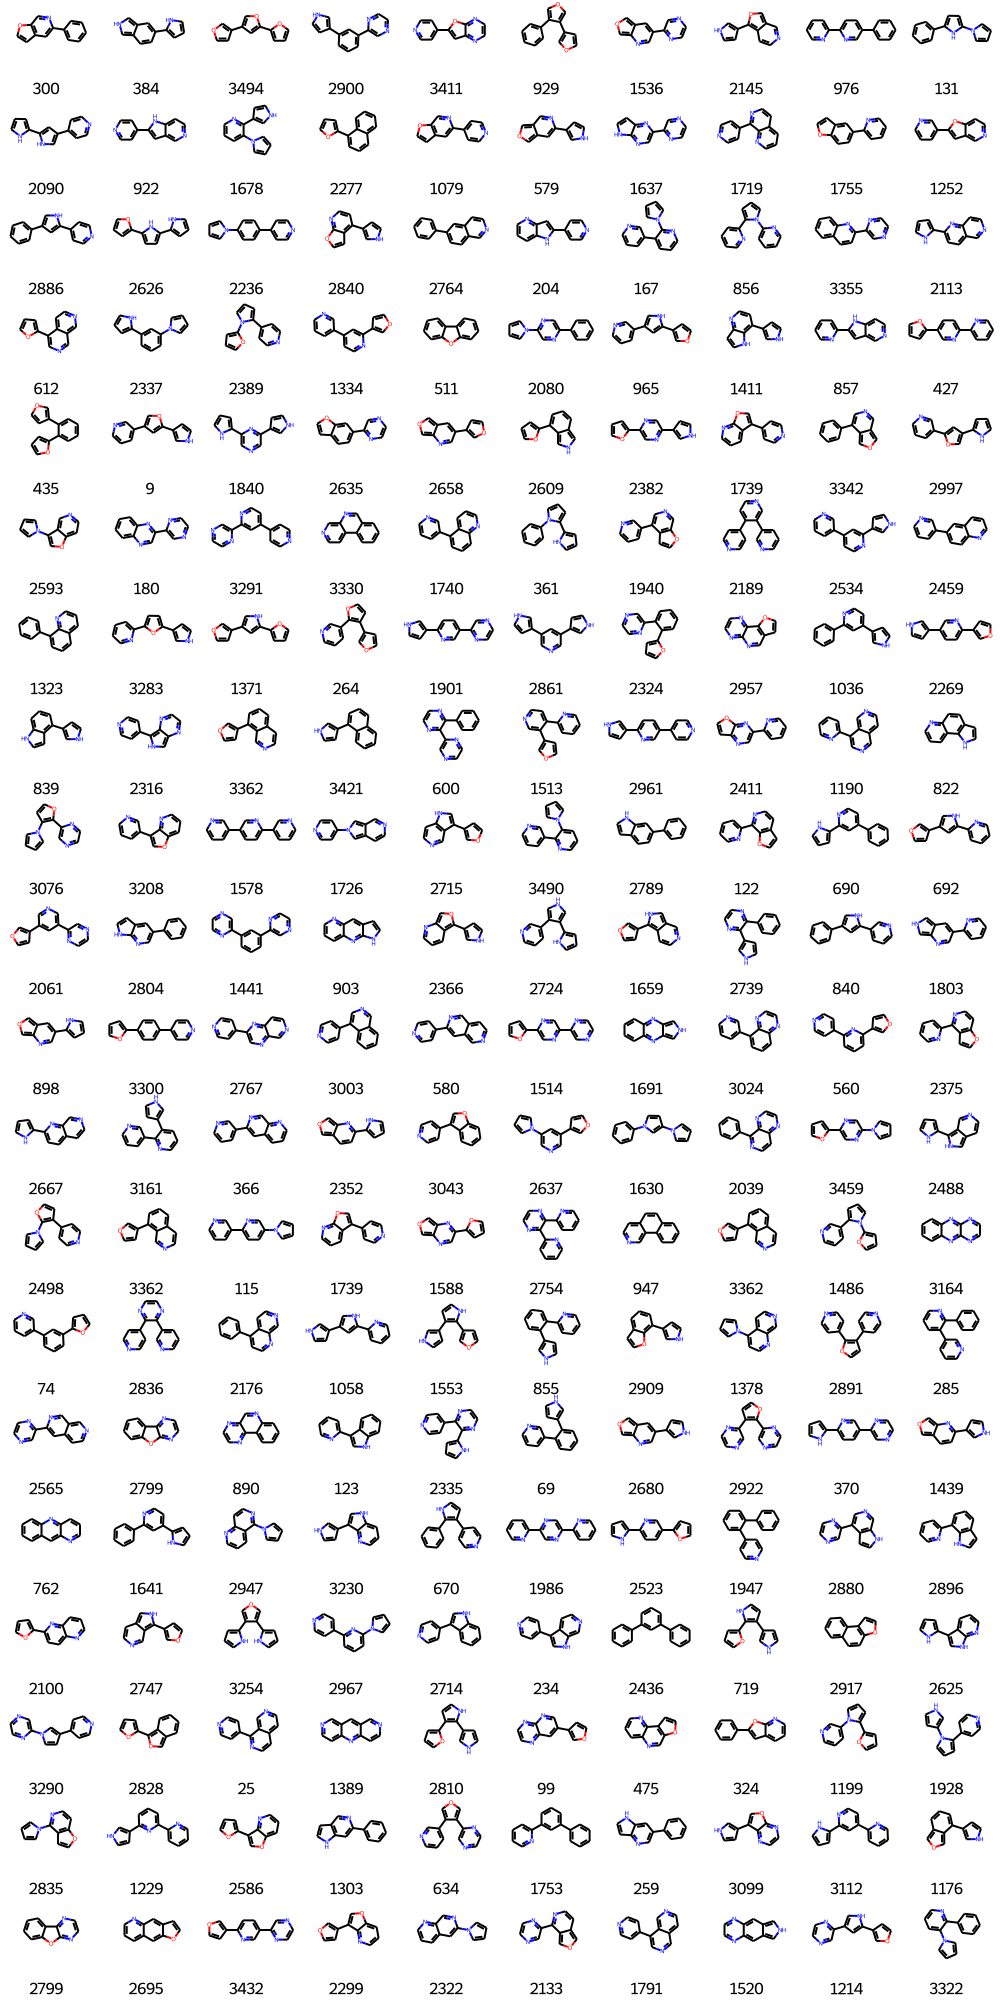

In [18]:
rand_indices = np.random.choice(np.arange(len(products2)), 200)
picks = products2[rand_indices]
mol_picks = [AllChem.MolFromSmiles(s) for s in picks]
labels = rand_indices.astype(str).tolist()
rdDraw.MolsToGridImage(mol_picks, legends = labels,
                       molsPerRow = 10, subImgSize=(100,100), maxMols=200)

# <i class="fa fa-check-circle-o"></i>  <br> Quantum Chemistry + Scharber Model

## Plan:


1. Convert the rdkit molecule to a PySCF molecule.
2. Calculate the molecule with a cheap electronic structure method.
3. Get the estimates for the HOMO energy and the LUMO energy
4. Apply the Scharber Model with the bandgap and data from solar spectrum




## Convert rdkit molecule to a pyscf molecule


Let's pick our favorite random molecule number **3433**:

In [19]:
#Convert SMILES to rdkit molecule
mol = AllChem.MolFromSmiles(products2[3433])
#Add all the hydrogen atoms: 
mol = AllChem.AddHs(mol)
#Get the coordinates of the atoms in 3D space. 
AllChem.EmbedMolecule(mol, params=AllChem.srETKDGv3())
# We can also try to optimize it with a force-field.
# AllChem.UFFOptimizeMolecule(m2) 
conf = mol.GetConformer()

But is it actually 3D?

In [20]:
drawMol3D(mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### Now we're ready to create a PYSCF molecule object

In [21]:
atom_block = [] 
for i, atom in enumerate(mol.GetAtoms()):
    pos = conf.GetAtomPosition(i) # Units are angstroms
    atom_block.append(f'{atom.GetSymbol()} {pos.x:.5f} {pos.y:.5f} {pos.z:.5f}')
atom_block = '; '.join(atom_block)
atom_block

'C 4.91149 1.01408 -0.56810; C 4.63529 0.31614 0.58728; N 3.38014 -0.01825 0.85759; C 2.36844 0.29408 0.05419; C 1.01426 -0.09356 0.39300; C 0.67054 -0.79156 1.53147; C -0.70874 -0.95047 1.46247; C -1.13931 -0.35201 0.30339; C -2.52227 -0.28727 -0.15912; C -3.65378 -0.79453 0.44573; C -4.75062 -0.50554 -0.33812; N -4.29575 0.16322 -1.39708; C -2.95721 0.31660 -1.32864; O -0.09541 0.13194 -0.28273; C 2.65111 0.99542 -1.10551; N 3.90251 1.34833 -1.40930; H 5.93157 1.28913 -0.79361; H 5.44985 0.05254 1.25541; H 1.32429 -1.15060 2.32660; H -1.33298 -1.44968 2.18127; H -3.64600 -1.32953 1.38664; H -5.76258 -0.79542 -0.08465; H -4.91268 0.51025 -2.16174; H -2.30985 0.82560 -2.05863; H 1.84770 1.26109 -1.77450'

In [22]:
pyscf_mol = pyscf.gto.M(atom = atom_block, verbose=4)
pyscf_mol.build()

System: uname_result(system='Linux', node='68512c2ba835', release='5.4.144+', version='#1 SMP Tue Dec 7 09:58:10 PST 2021', machine='x86_64', processor='x86_64')  Threads 2
Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
numpy 1.21.5  scipy 1.4.1
Date: Tue Mar 22 18:49:55 2022
PySCF version 1.7.6
PySCF path  /usr/local/lib/python3.7/dist-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 25
[INPUT] num. electrons = 110
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT]  1 C      4.911490000000   1.014080000000  -0.568100000000 AA    9.281370963540   1.916333468399  -1.073553411365 Bohr
[INPUT]  2 C      4.635290000000   0.316140000000   0.587280000000 AA    8.759428607935   0.597418017020   1.109798358435 Bohr
[INPUT]  3 N      3.380140000000  -0.018250000000   0.857590000000 AA    6.387538862687  -0.034487501773   1.620610227166 Bohr
[INPUT]  4 C      2.368440

## Perform an Electronic Structure Calculation with the MINDO/3 SemiEmpirical Method
Since we are going to have to run a TON of electronic structure calculations, and we are doing this in our little virtual machines, we can't really afford to run a ton of Hartree-Fock or DFT calculations.  (Although you may want to try it if you're really brave and want to see how well your laptop performs!!!)

Remember MINDO/3 is a semi-empirical method! Keep that in mind when we produce predictions in this exercise.

In the real world of Quantum Chemistry Research, you would want to have access to a huge cluster which would let you run methods such as **MP2**, **DFT**, or even **Linear Scaling Coupled Cluster Methods** on the huge set of molecules, in order to make sure that your predictions are extremely accurate.  


In [23]:
mindo3_mol = MINDO3(pyscf_mol)
mindo3_mol.kernel()



******** <class 'pyscf.semiempirical.mindo3.RMINDO3'> ********
method = RMINDO3-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-05
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /content/tmpn6jjt6dj
max_memory 4000 MB (current use 264 MB)
Set gradient conv threshold to 0.00316228
init E= -69.6410725274229
  HOMO = -0.162143926977344  LUMO = -0.113423175006877
cycle= 1 E= -93.2296246523383  delta_E= -23.6  |g|= 0.324  |ddm|= 8.37
  HOMO = -0.23999740539072  LUMO = 0.034379896013014
cycle= 2 E= -93.3100596210737  delta_E= -0.0804  |g|= 0.0954  |ddm|= 0.743
  HOMO = -0.252968523625607  LUMO = 0.0278706998021907
cycle= 3 E= -93.316582947976  delta_E= -0.00652  |g|= 0.0399  |ddm|= 0.201
  HOMO = -0.255735698066347  LUMO = 0.0310691062264833
cycle= 4 E= -93.3181977245005  delta_E= -0.00161  |g|= 0.017  |ddm|= 0.1

-93.31870553502853

## Get HOMO and LUMO Energies


For this we have at our disposal the following methods:

* Molecular Orbital Energies (**mo_energies**), an array of energy values for each MO orbital.
* Occupancy of orbitals (**mo_occ**), useful if you want to play with occupied/unoccupied.

In [24]:
hartree_to_ev = lambda x: x*27.2107

occ = mindo3_mol.mo_occ
energies = mindo3_mol.mo_energy
print(f'Orbital occupancy: {occ}')
print(f'Orbital energies: {energies}')
occ_indices = np.arange(len(occ))
homo_index = occ_indices[occ>0].max()
lumo_index = occ_indices[occ==0].min()
homo = hartree_to_ev(energies[homo_index])
lumo =  hartree_to_ev(energies[lumo_index])
gap = lumo-homo
print(homo, lumo)
gap

Orbital occupancy: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
Orbital energies: [-1.48263905 -1.41959746 -1.33536499 -1.15619536 -1.06995726 -1.06112182
 -1.00999703 -0.99941215 -0.92723966 -0.81269654 -0.80225458 -0.73738196
 -0.72170339 -0.68147916 -0.65921361 -0.63440746 -0.5874791  -0.57914392
 -0.56910619 -0.5301005  -0.50918351 -0.49731825 -0.49714187 -0.46520853
 -0.45519498 -0.44068762 -0.42419847 -0.41293515 -0.40694683 -0.38058073
 -0.37282338 -0.36734414 -0.36733499 -0.35980933 -0.35050176 -0.33241496
 -0.31259135 -0.27609509 -0.25870643  0.03319282  0.05265279  0.05451598
  0.05578387  0.06593823  0.08287685  0.08461965  0.10631403  0.11244607
  0.1136597   0.11862677  0.12899165  0.13552813  0.1365239   0.1485177
  0.15043615  0.15711587  0.16004085  0.17554053  0.18357363  0.18800706
  0.193817

7.9427828327666345

But this molecule will actually the play the role of a electron donor (to a electron acceptor) in a short circuit!

[![](https://github.com/beangoben/molecular_screening_lecture/blob/main/media/PCBM.png?raw=1)](https://en.wikipedia.org/wiki/Phenyl-C61-butyric_acid_methyl_ester)

In [25]:
fudge_factor = 5
donor_homo = homo
donor_lumo =  lumo - fudge_factor
gap = donor_lumo - donor_homo
gap

2.9427828327666345

#### Did you notice that mysterious variable called the fudge_factor?
Basically, we're shifting the the LUMO energy down by that fudge factor, many times calcualtions will not compare directly with experiment so it is nesesary to introduce a calibration in order to give predictive power to calculations.

This is where the **''fudge factor''** comes in..  That's how crappy the semi-empirical methods perform for this particular application.

But nevermind, the point is to get a feel for high-throughput, large scale quantum chemistry calculations for molecular screening. 

### Question:  What color of light will this molecule absorb?

In [26]:
ev_to_nm = lambda x: np.clip(1239.8424121/x, 0, np.inf)
gap_nm = ev_to_nm(gap)
print(f'the HOMO-LUMO gap, in wavelength (nanometers), is ----> {gap_nm:.2f} nm')

the HOMO-LUMO gap, in wavelength (nanometers), is ----> 421.32 nm


## Making prections with the Scharber Model 

We can use the Scharber Model to predict the solar cell conversion efficiency if we were to use that molecule as an electron donor in an organic solar cell. 

In order to predict the energy conversion efficiency, we need the solar spectrum. Specifically, we want to rate at which energy from the sun hits the surface of the earth as a function of wavelength. 
<br>
### <i class="fa fa-sun-o"></i> Load the solar spectrum data 
Don't worry to much about the code, we just want to load the data in to some arrays


In [27]:
solar_df = pd.read_csv('data/AM15_PhotFlux_rev.csv')
solar_df

,Wavelength (nm),Global Tilt (W m-2 nm-1),Flux (W m-2)
0,280.0,4.730900e-23,1.068404e-23
1,280.5,1.230700e-21,2.784318e-22
2,281.0,5.689500e-21,1.289479e-21
3,281.5,1.566200e-19,3.555980e-20
4,282.0,1.194600e-18,2.717098e-19
...,...,...,...
1997,3980.0,7.387200e-03,2.371355e-02
1998,3985.0,7.432700e-03,2.388959e-02
1999,3990.0,7.372300e-03,2.372518e-02
2000,3995.0,7.210000e-03,2.323195e-02


In [28]:
wavelength = solar_df['Wavelength (nm)'].to_numpy()
power = solar_df[' Global Tilt (W m-2 nm-1)'].to_numpy()
flux = solar_df[' Flux (W m-2)'].to_numpy()
print(wavelength.shape, power.shape, flux.shape)

(2002,) (2002,) (2002,)


### <i class="fa fa-line-chart"></i> Graph the solar spectrum
Wavelength vs power

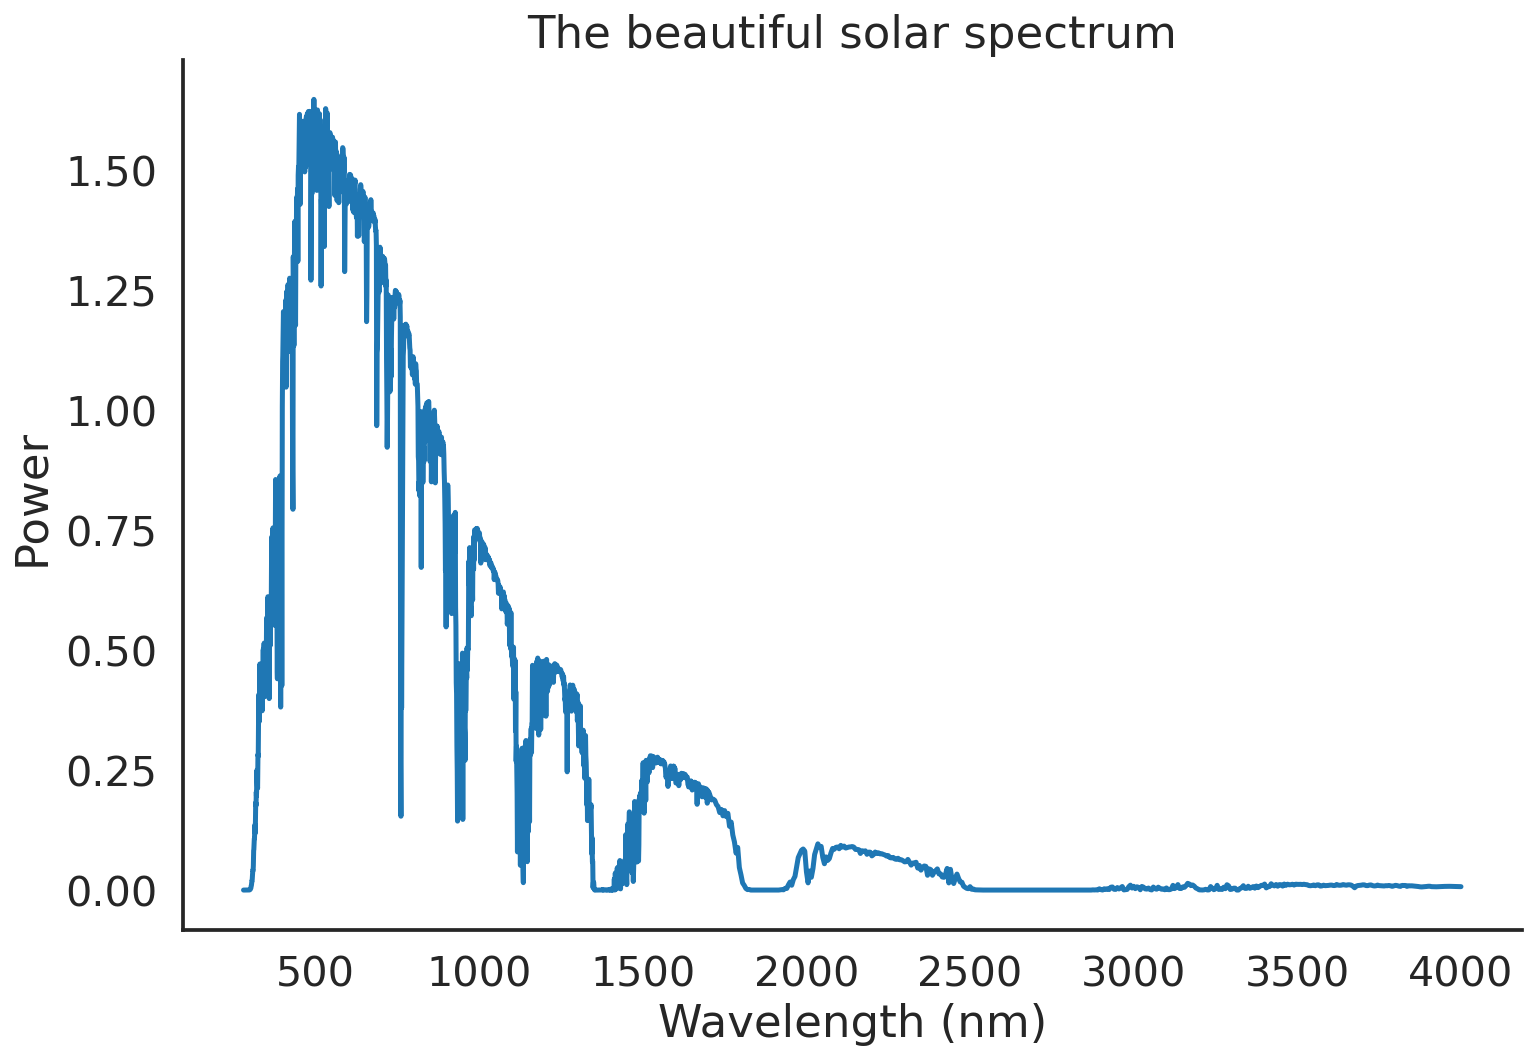

In [29]:
plt.plot(wavelength, power)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power ')
plt.title("The beautiful solar spectrum")
sns.despine()
plt.show()

### <i class="fa fa-question-circle"></i>  Questions?

* Which part of the spectrum corresponds to visible light?
* Is there a a maxima? Which color corresponds to this wavelength?


In [30]:
#@title
def wavelength_to_rgb(wavelength):
    '''This converts a given wavelength of light to an
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html

    '''
    w = int(wavelength)

    # colour
    if w >= 380 and w < 440:
        R = -(w - 440.) / (440. - 350.)
        G = 0.0
        B = 1.0
    elif w >= 440 and w < 490:
        R = 0.0
        G = (w - 440.) / (490. - 440.)
        B = 1.0
    elif w >= 490 and w < 510:
        R = 0.0
        G = 1.0
        B = -(w - 510.) / (510. - 490.)
    elif w >= 510 and w < 580:
        R = (w - 510.) / (580. - 510.)
        G = 1.0
        B = 0.0
    elif w >= 580 and w < 645:
        R = 1.0
        G = -(w - 645.) / (645. - 580.)
        B = 0.0
    elif w >= 645 and w <= 780:
        R = 1.0
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0

    # intensity correction
    if w >= 380 and w < 420:
        SSS = 0.3 + 0.7*(w - 350) / (420 - 350)
    elif w >= 420 and w <= 700:
        SSS = 1.0
    elif w > 700 and w <= 780:
        SSS = 0.3 + 0.7*(780 - w) / (780 - 700)
    else:
        SSS = 0.0
    SSS *= 255

    return [int(SSS*R), int(SSS*G), int(SSS*B)]

def plot_color(color):
    color = ast.literal_eval(color) if isinstance(color, str) else color
    plt.figure(figsize=(0.5,0.5))
    im = np.zeros((20,20,3))
    im[:,:,0]=color[0]/255.0
    im[:,:,1]=color[1]/255.0
    im[:,:,2]=color[2]/255.0
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    return

def plot_wavelength(x):
  plot_color(wavelength_to_rgb(x))


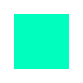

In [31]:
plot_wavelength(wavelength[np.argmax(power)])

Also let's not forget we also have flux

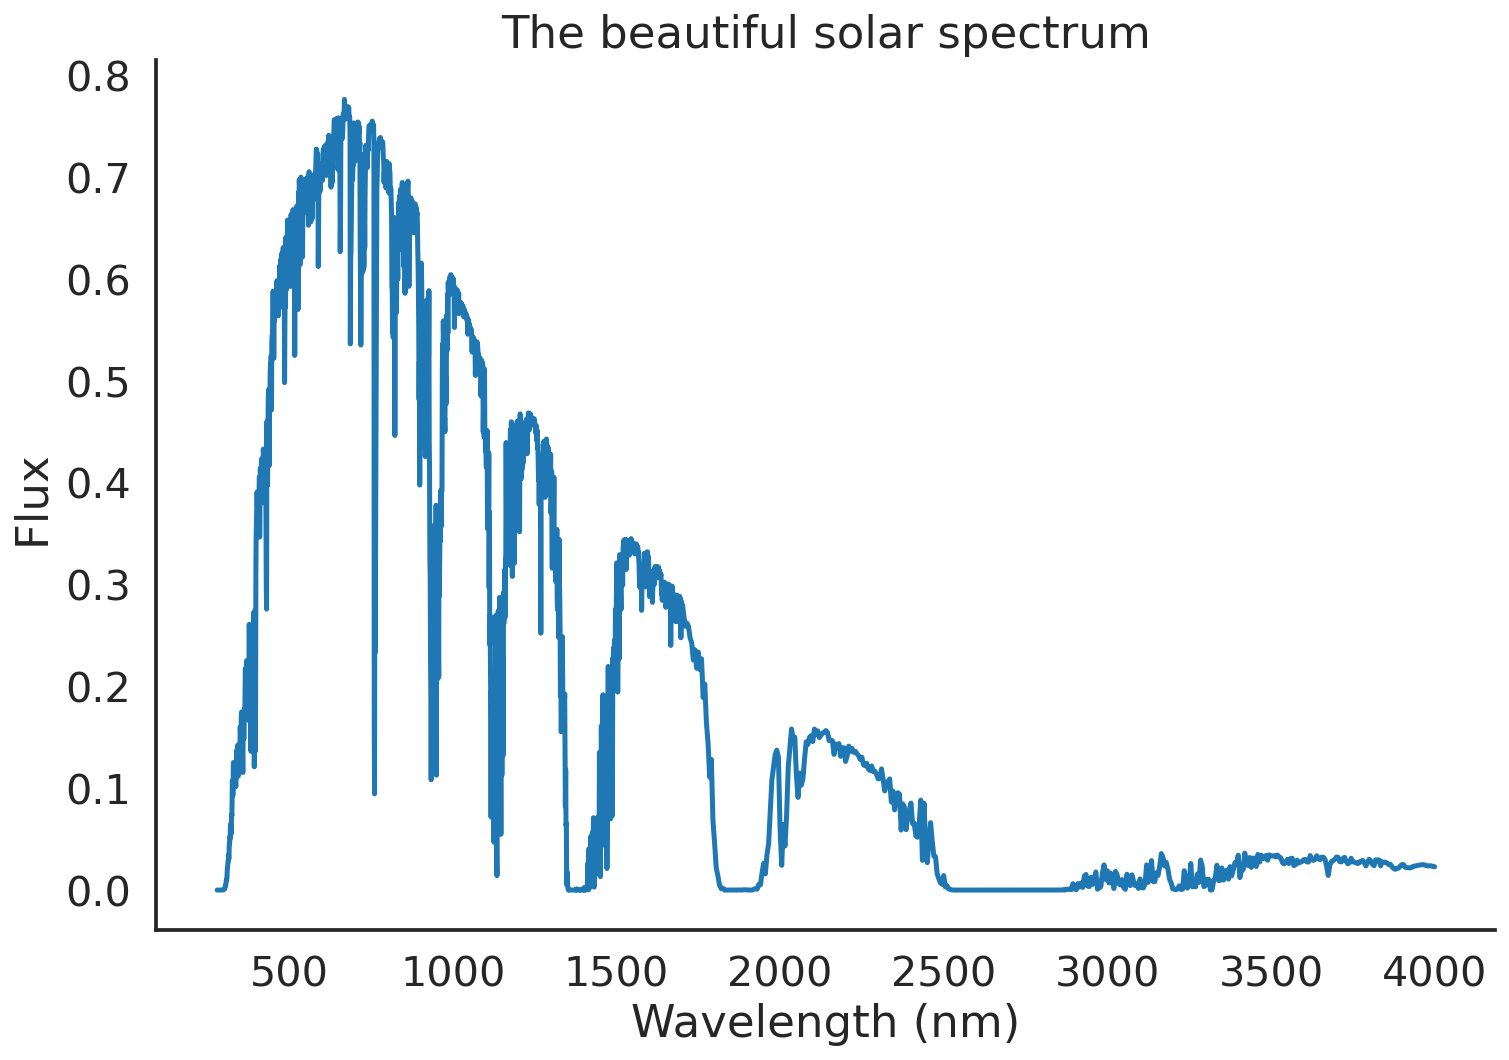

In [32]:
plt.plot(wavelength, flux)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux ')
plt.title("The beautiful solar spectrum")
sns.despine()
plt.show()

### Putting it all together: Scharber model
Now we'll define a function that, given the **HOMO**, **LUMO**, **power spectrum** (power, wavelength, flux), returns the predicted **Power Conversion Efficiency** (PCE) via the Scharber model.

Although the Scharber model is pretty straightforward, and can be thought of as a specialized version of the [Shockley-Queisser model](https://en.wikipedia.org/wiki/Shockley%E2%80%93Queisser_limit), it is beyond the scope of this iPython notebook to delve into the derivaition.  so lets just use it as a blackbox function. 

In [33]:
def scharber_efficiency(donor_homo, donor_lumo, power, wavelength, flux):
  """Calculate PCE via the sharber model."""
  full_power = sp.integrate.simps(power, wavelength)
  #This is the LUMO energy, in eV, of the acceptor molecule, PCBM.
  pcbm_l=-4.3
  
  # This is the open circuit voltage
  voc=abs(donor_homo)-abs(pcbm_l)-0.3

  #This is the bandgap, in nano-meters
  bandgap_ev = abs(donor_lumo-donor_homo)
  bandgap_nm = 1239.8424121/bandgap_ev

  # Olny consider wavelengths of the solar spectrum shorter than
  # the band gap wavelength
  mask = np.logical_and(wavelength <= bandgap_nm, wavelength <=720)
  if mask.sum():
    #This is the short circuit current
    jsc = sp.integrate.simps(flux[mask], wavelength[mask])
    #This is called the Fill Factor
    jsc = jsc*0.65 # Take away 0.65 for 26%
  else:
    jsc = 0.0
  
  #Finally, this is the efficiency
  pce = 100*voc*jsc/full_power
  
  return np.clip(pce, 0, 100), bandgap_nm

Let's see it in **full color**

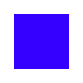

The Power Conversion Efficiency is ----> 3.44
The Dye color of 2.94 eV bandgap is [53, 0, 255]


In [34]:
pce, gap_nm = scharber_efficiency(donor_homo, donor_lumo, power, wavelength,flux)
color = wavelength_to_rgb(gap_nm)
plot_color(color)
print(f'The Power Conversion Efficiency is ----> {pce:.2f}')
print(f'The Dye color of {gap:.2f} eV bandgap is {str(color)}')

# <i class="fa fa-check-circle-o"></i>  Molecular Screening Party

### Now, show us what you've learned in this course by repeating all the steps we did above but for a random set of N molecules!!  YEAH!!!!!

Where **N** is your favorite number larger than 50.

But first, make use of good programming practices by wrapping each module/step of what we've done above in a set of little functions. 

Note that we have worked out above all the pieces of the puzzle above!


![](https://github.com/beangoben/molecular_screening_lecture/blob/main/media/Background.png?raw=1)



### <i class="fa fa-code"></i> Get conformer coordinates from smiles

In [35]:
def smiles_to_3dmol(smiles):
    #Convert SMILES to rdkit molecule
    mol = AllChem.MolFromSmiles(smiles)
    #Add all the hydrogen atoms: 
    mol = AllChem.AddHs(mol)
    #Get the coordinates of the atoms in 3D space. 
    AllChem.EmbedMolecule(mol, params=AllChem.srETKDGv3())
    return mol

### <i class="fa fa-code"></i> MINDO/3 electronic structure calculation


In [36]:
def mindo3_calc(mol):
  conf = mol.GetConformer()
  # Build atom/coordinate block.
  atom_block = [] 
  for i, atom in enumerate(mol.GetAtoms()):
      pos = conf.GetAtomPosition(i) # Units are angstroms
      atom_block.append(f'{atom.GetSymbol()} {pos.x:.5f} {pos.y:.5f} {pos.z:.5f}')
  atom_block = '; '.join(atom_block)
  # Make pyscf molecule.
  pyscf_mol = pyscf.gto.M(atom = atom_block, verbose=0)
  pyscf_mol.build()
  # Make semi-emphirical calculation
  mindo3_mol = MINDO3(pyscf_mol)
  mindo3_mol.kernel()
  return mindo3_mol

### <i class="fa fa-code"></i> Get HOMO and LUMO energies
write a function called getHOMO_LUMO which takes as input the output of mindo3_calc, and returns the HOMO and LUMO energies. Include the fudgefactor!

In [37]:
HARTREE_TO_EV = 27.2107

def get_donor_homolumo(mindo3_mol):
  occ = mindo3_mol.mo_occ
  energies = mindo3_mol.mo_energy
  occ_indices = np.arange(len(occ))
  homo_index = occ_indices[occ>0].max()
  lumo_index = occ_indices[occ==0].min()
  donor_homo = energies[homo_index]*HARTREE_TO_EV
  lumo =  energies[lumo_index]*HARTREE_TO_EV
  fudge_factor = 5
  donor_lumo= lumo -fudge_factor
  return donor_homo, donor_lumo

## Get the PCE for a random subset of N  molecules, storing it in an array!

Now generate a random set of indices between **0 and (len(products2) - 1)**.

That's the library that you'll analyze!

In [38]:
n=100
indices = np.random.choice(np.arange(len(products2)), 100)

Using the functions you defined above, get the Power Conversion Efficiency (PCE) of every molecule in your subset while also storing information.


In [39]:
data = []
library_name = 'scorpion'
pbar = tqdm.tqdm(enumerate(indices), total=len(indices))
for i, index in pbar:
  smi = products2[index]
  mol = smiles_to_3dmol(smi)
  mindo3_mol = mindo3_calc(mol)
  donor_homo, donor_lumo = get_donor_homolumo(mindo3_mol)
  pce, gap_nm = scharber_efficiency(donor_homo, donor_lumo, power, wavelength,flux)
  result = {'index':index,
            'library': library_name,
            'smiles': smi,
            'pce': pce,
            'gap_nm': gap_nm,
            'color': str(wavelength_to_rgb(gap_nm)),
            }
  pbar.set_postfix({'pce':pce})
  data.append(result)

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
result_df = pd.DataFrame(data)
result_df

,index,library,smiles,pce,gap_nm,color
0,1950,scorpion,c1ccn(-c2ccncc2-c2cnccn2)c1,2.554517,398.869318,"[92, 0, 198]"
1,1596,scorpion,c1cnc(-c2cncc3c[nH]cc23)cn1,10.677997,504.889015,"[0, 255, 76]"
2,3273,scorpion,c1coc(-c2cc[nH]c2-c2ccco2)c1,1.028645,362.457092,"[0, 0, 0]"
3,2800,scorpion,c1c[nH]c(-c2cncc(-c3ccoc3)n2)c1,0.701414,350.637832,"[0, 0, 0]"
4,2429,scorpion,c1cc(-c2ccncc2-c2ccncc2)ccn1,0.199999,327.066045,"[0, 0, 0]"
...,...,...,...,...,...,...
95,1371,scorpion,c1coc(-c2cc(-c3ccoc3)c[nH]2)c1,1.754459,386.959428,"[100, 0, 168]"
96,3206,scorpion,c1ccc(-c2c[nH]cc2-c2ccco2)nc1,0.248798,330.726255,"[0, 0, 0]"
97,2157,scorpion,c1c[nH]c(-n2ccc3nccnc32)c1,2.513975,402.909820,"[88, 0, 209]"
98,2152,scorpion,c1cnc(-c2ccc(-c3cc[nH]c3)cc2)cn1,1.610230,377.018297,"[0, 0, 0]"


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

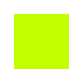

The Power Conversion Efficiency is ----> 18.44
The Dye color of 564.35 nm bandgap is [196, 255, 0]


In [43]:
best_index = result_df['pce'].argmax()
row = result_df.iloc[best_index]
mol = smiles_to_3dmol(row['smiles'])
drawMol3D(mol)
plot_color(row["color"])
print(f'The Power Conversion Efficiency is ----> {row["pce"]:.2f}')
print(f'The Dye color of {row["gap_nm"]:.2f} nm bandgap is {row["color"]}')

### Histogram!
A histogram will gives an idea if we found some good molecules and how many

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


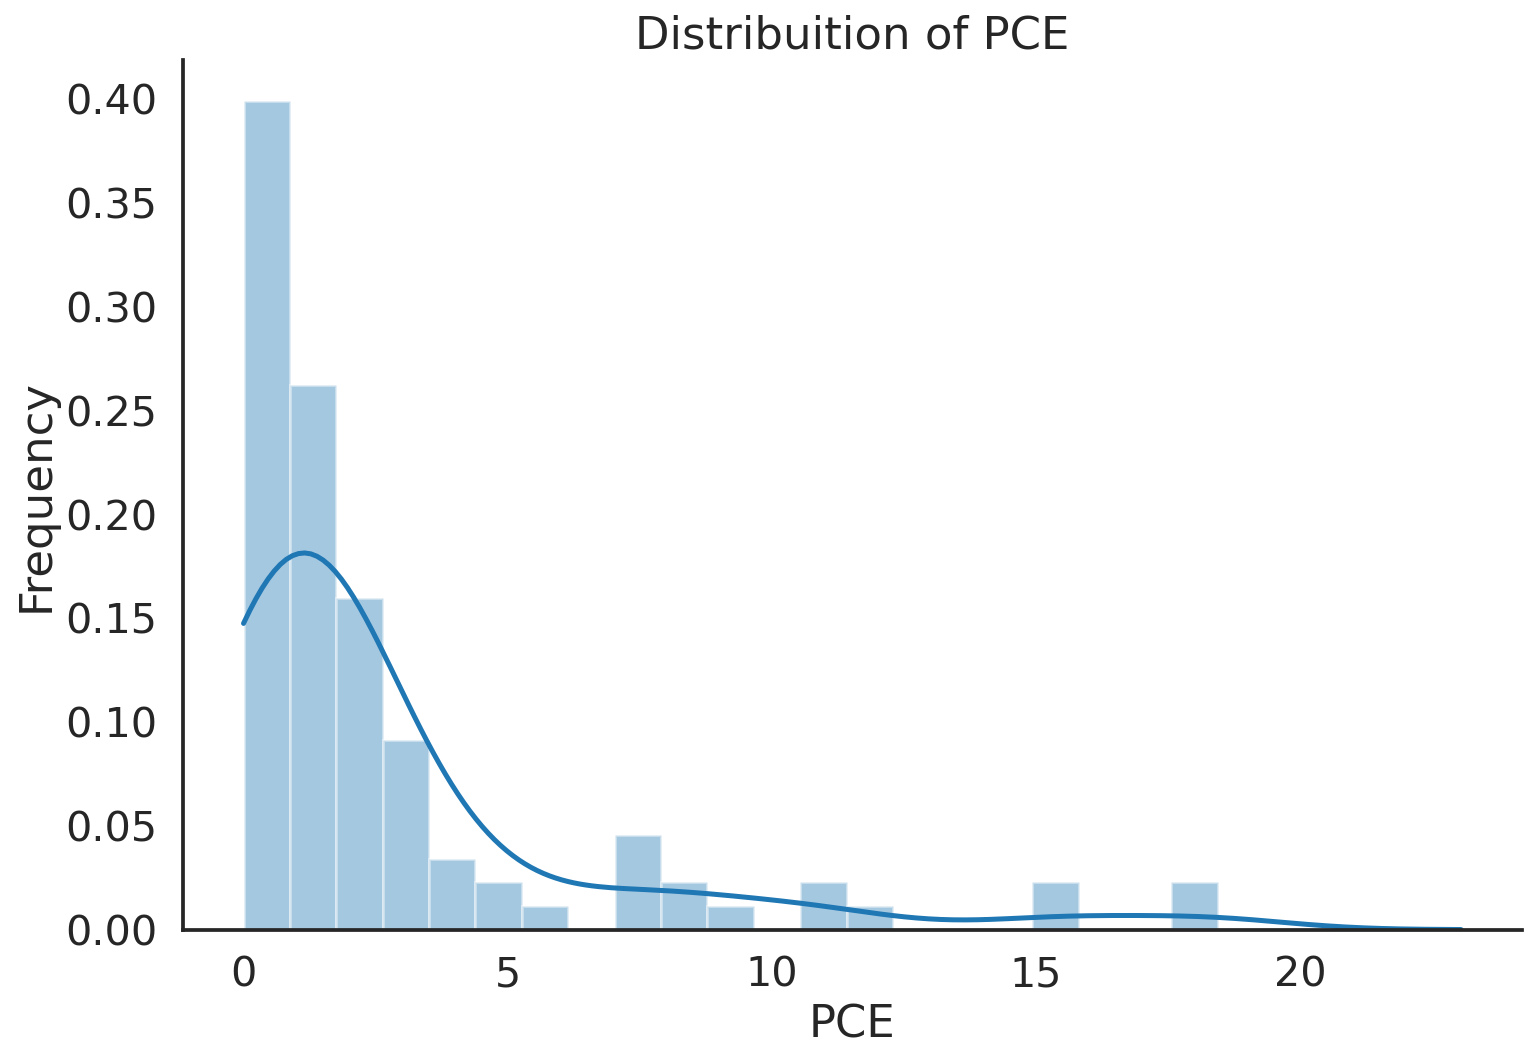

In [49]:
sns.distplot(result_df['pce'], kde_kws={'clip': (0.0, 100.0)})
plt.ylabel("Frequency")
plt.xlabel("PCE")
plt.title('Distribuition of PCE')
sns.despine()
plt.show()

## Competition time !
* ### Think of ways of creating better performing molecules.
* ### Generate a table of candidate molecules.
* ### Send your top 10 molecules.
* ### Share your results by uploading a your data in a google spreadsheet.



## Will your molecule reign supreme?


![](https://github.com/beangoben/molecular_screening_lecture/blob/main/media/molwinner.png?raw=1)